In [1]:
import pickle
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# load mlm data and vocabulary class

class Vocabulary:
    def __init__(self):
        self.special_toks = ['<pad>','<sep>','<mask>','<unk>','<cls>']
        self.w2i = {'<pad>':0,'<sep>':2,'<mask>':1,'<unk>':3,'<cls>':4}
        self.i2w = {self.w2i[k]:k for k in self.w2i}
        self.size = 5
        self.wc = {}
        
    def __call__(self,text):
        
        for sent in text:
            words = sent.split()
            for w in words:
                if w not in self.w2i:
                    self.w2i[w] = self.size
                    self.i2w[self.size] = w
                    self.size += 1
                    
                    self.wc[w] = 1
                    
                else:
                    self.wc[w] += 1
                    
        self.wc = dict(sorted(self.wc.items(), key=lambda x: x[1], reverse=True))
        
    def tokenize(self,seq):
        seq = seq.split()
        for i,w in enumerate(seq):
            if w not in self.wc:
                seq[i] = 3
            else:
                seq[i] = self.w2i[w]
                
        return seq
                
    def add_padding(self,seq,maxlen):
        padding = [0]*(maxlen - len(seq))
        return seq + padding
        
if __name__ == "__main__":

    with open('vocab.pkl','rb') as f:
        vocab = pickle.load(f)
        
with open('pretraining data.pkl','rb') as f:
    data = pickle.load(f)

In [3]:
%cd C:/Users/BJS/PycharmProjects/pythonProject1

C:\Users\BJS\PycharmProjects\pythonProject1


In [4]:
# function to create positional encoding weights

def positional_encoding(emb_dim,maxlen):
    pos = np.zeros((maxlen, emb_dim), dtype=np.float32)
    for p in range(maxlen):
        for i in range(emb_dim):
            if i % 2 == 0:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.sin(angle)
            else:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.cos(angle)
                
    return pos

<AxesSubplot: >

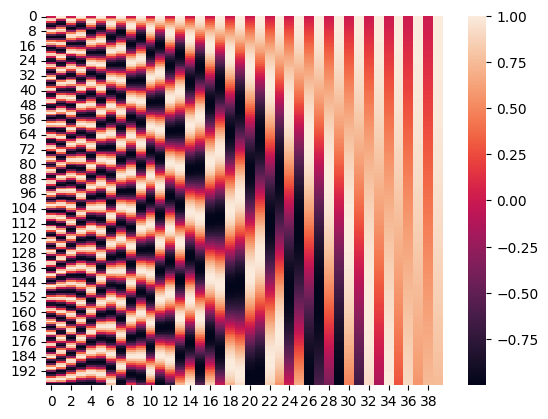

In [5]:
# define parameters

batch = 32
d_model = 128
n_heads = 8
units = d_model * 2
vocab_size = vocab.size
n_layers = 3
maxlen = len(data['train']['masked_seq'][0])

encodings = positional_encoding(d_model,maxlen)

sb.heatmap(encodings[:,:40])

In [6]:
# build BERT for MLM task

from bert import BERT
from pretraining import BertMLM

bert_model = BERT(d_model=d_model, n_heads=n_heads, n_encoder_layer=n_layers, 
                  units=units, pos_weights=encodings, vocab_size=vocab.size) 

model = BertMLM(bert_model,mlm_units=vocab.size)

seq = tf.keras.layers.Input((maxlen,),batch_size=batch)
seg = tf.keras.layers.Input((maxlen,),batch_size=batch)

model.build([seq.shape]*2)

model.summary([seq,seg])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(32, 200)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(32, 200)]          0           []                               
                                                                                                  
 bert (BERT)                    (32, 200, 128)       12438016    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (32, 200, 95935)     12375615    ['bert[0][0]']               

In [7]:
# prepare data

train = (data['train']['masked_seq'],data['train']['segment_ids'],data['train']['inv_mask'])
val = (data['valid']['masked_seq'],data['valid']['segment_ids'],data['valid']['inv_mask'])

train = tf.data.Dataset.from_tensor_slices(train).batch(batch_size=batch,drop_remainder=True).shuffle(buffer_size=100)
val = tf.data.Dataset.from_tensor_slices(val).batch(batch_size=batch,drop_remainder=True).shuffle(buffer_size=100)

<AxesSubplot: >

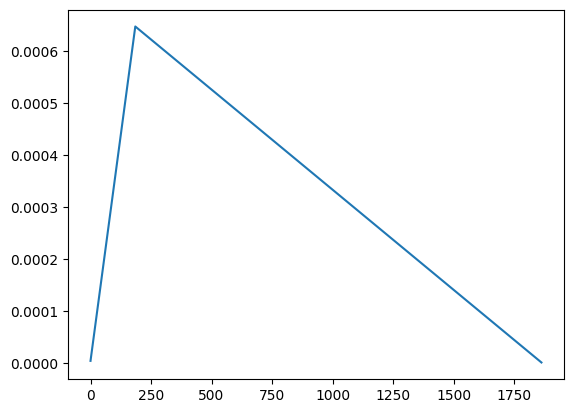

In [8]:
# linear warmup and decay lr scheduler class

class CustomLRScheduler:
    def __init__(self,emb_size,end_lr,total_steps):
        self.emb_size = emb_size**-0.5
        self.end = end_lr
        self.total = total_steps
        self.warmup = total_steps//10
        self.decay = total_steps - self.warmup
        self.max = None
    
    def __call__(self,step):
        
        if step<=self.warmup:
            incr_rate = step*self.warmup**-1.5
            self.max = self.emb_size*incr_rate/10
            return self.emb_size*incr_rate/10
        else:
            step -= self.warmup
            lr_diff = self.max - self.end
            decay_rate = 1-step/self.decay
            return lr_diff * decay_rate + self.end
        

total_steps = len(data['train']['inv_mask'])//batch
lr = 0.0

# visulaize lr change of custom scheduler
custom_lr_sch = CustomLRScheduler(d_model,lr,total_steps)
sb.lineplot([custom_lr_sch(s) for s in range(1,total_steps)])

In [9]:
# load the nsp pretrained weights
model.layers[0].load_weights('nsp_bert.h5')

In [10]:
# create sample inputs to monitor token prediction after each epoch
x = (np.expand_dims(data['valid']['masked_seq'][-1],0),np.expand_dims(data['valid']['segment_ids'][-1],0))
y = data['valid']['inv_mask'][-1]

In [11]:
model.train(train,val,epochs=10,lr_scheduler=custom_lr_sch,sample_x=x,sample_y=y,vocab=vocab)

epochs : 1/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:13<00:00,  2.77it/s]


train loss : 0.89803
val loss : 0.88839
weights saved

predicted tokens : movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie movie
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 2/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:10<00:00,  2.78it/s]


train loss : 0.86864
val loss : 0.88313
weights saved

predicted tokens : movie movie film film film film film film film film film film film film film film film film film film film film film film film
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 3/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:10<00:00,  2.78it/s]


train loss : 0.8606
val loss : 0.87536
weights saved

predicted tokens : movie film film his have but he he have he he he he he he are are but you you are are are you you
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 4/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:10<00:00,  2.78it/s]


train loss : 0.84584
val loss : 0.85812
weights saved

predicted tokens : have movie he her he have he he have he film are film film film they movie you you be movie movie movie film movie
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 5/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:11<00:00,  2.78it/s]


train loss : 0.82092
val loss : 0.83028
weights saved

predicted tokens : have movie he he he he movie movie seen he but they but his on movie you but you you movie film but movie but
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 6/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:10<00:00,  2.78it/s]


train loss : 0.78586
val loss : 0.79279
weights saved

predicted tokens : been movie he one an he film movie on an he good good or some movie but my you you good film but good but
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 7/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:11<00:00,  2.78it/s]


train loss : 0.74264
val loss : 0.75635
weights saved

predicted tokens : came first has one well what movie way on an who good well be but movie but what you do few very are movie at
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 8/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:11<00:00,  2.78it/s]


train loss : 0.70733
val loss : 0.73708
weights saved

predicted tokens : came first has one well what movie way on an who good well have but movie all what you do few good has movie watching
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 9/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:12<00:00,  2.77it/s]


train loss : 0.68062
val loss : 0.72646
weights saved

predicted tokens : him first has one well what movie way on an or good well they but movie said what you do great good has movie on
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on

epochs : 10/10


100%|██████████████████████████████████████████████████████████████████████████████| 1865/1865 [11:12<00:00,  2.77it/s]


train loss : 0.65836
val loss : 0.72054
weights saved

predicted tokens : him first had one well what movie way on my or good well they up movie said what you do great good has movie watching
actual tokens : start young died basically traumatized he children education very its shop delicate incest particularly suicide film anything subsequently making may glorified student has cinema on



In [12]:
# load the best weights and save the bert part

model.load_weights('best_mlm.h5')
bert_model = model.layers[0]
bert_model.save_weights('mlm_bert.h5')

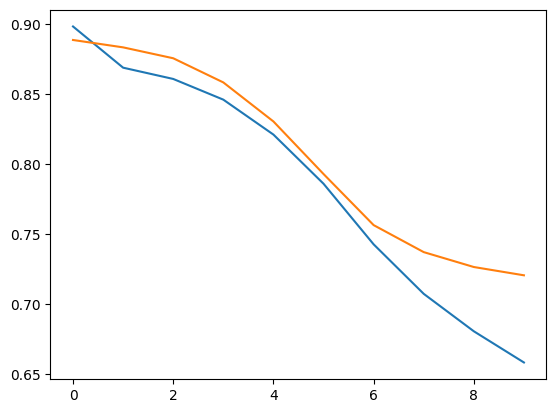

In [13]:
# plot training losses

plt.plot(model.epoch_loss['train'])
plt.plot(model.epoch_loss['val'])

In [14]:
# MLM model results

idx = np.random.randint(0,999,5)

for i in idx:
    x = (np.expand_dims(data['valid']['masked_seq'][i],0),np.expand_dims(data['valid']['segment_ids'][i],0))
    y = data['valid']['inv_mask'][i]
    pred = model(x,training=False).numpy()[0]
    pred = np.argmax(pred,axis=-1)
    mseq = x[0][0].copy()
    mseq_idx = np.where(mseq == 1)[0]
    mseq[mseq_idx] = pred[mseq_idx]
    actual = data['valid']['seq'][i]
    
    print('masked :',' '.join([vocab.i2w[t] for t in x[0][0] if t>0]))
    print()
    print('actual :',' '.join([vocab.i2w[t] for t in actual if t>0]))
    print()
    print('pred :',' '.join([vocab.i2w[t] for t in mseq if t>0]))
    
    
    print('---------------------------------')
    
    

masked : <cls> the <mask> particulars of this insidiously vapid movie is akin to <mask> into <mask> chest cavity with a rusty salted spoon perhaps home alone lost in new york was a bit on the predictable side <mask> this pathetic excuse for a film is just one of the most <mask> bids at <mask> i have ever <mask> of a <mask> <sep> few scenes that <mask> cut and seemed to be a little shorter <mask> they should have been i looked this <mask> and it seems that minutes was cut from the film since its original showing <mask> the toronto film festival also the ending was pretty <mask> and i was expecting a little more from it or maybe <mask> paragraphs to come on the screen to tell the audience more about bettie page life where the film left <mask> those are <mask> only two <mask> about the film <mask> <mask> that the directing was <mask> the acting was great <sep>

actual : <cls> the dirty particulars of this insidiously vapid movie is akin to digging into your chest cavity with a rusty salte

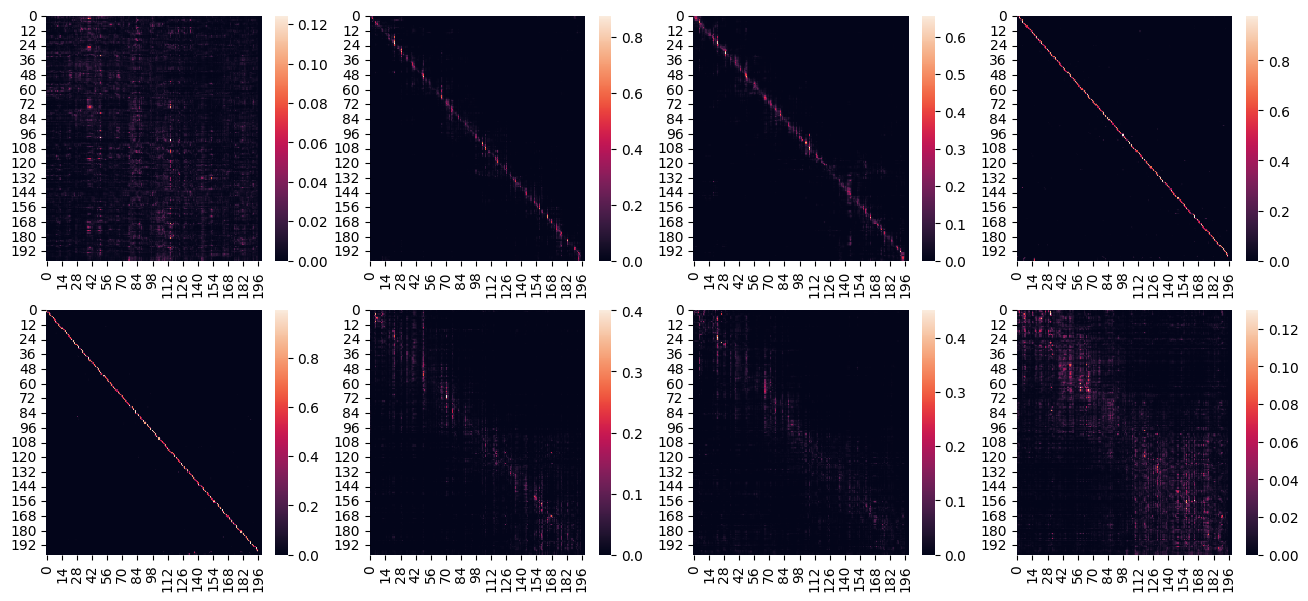

In [16]:
# plot attention weights

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(model.layers[0].layers[1].mhsa.attention_scores[0].numpy(),
                              (2,4,maxlen,maxlen))[i][j],ax=ax[i][j])
plt.show()